In [1]:
import time
import skimage
from skimage.measure import block_reduce

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir(".")
import parc.data.data_em as data
#from parc import misc, metrics, visualization
from parc.model import model_em as model

2024-06-24 12:01:57.366681: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 12:02:02.018799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78699 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0


## Reshaping Data to fit PARCv2

In [2]:
path = '/scratch/pdy2bw/class5_complete/class5_16.npy'

raw_data = np.float32(np.load(path))
data_shape = raw_data.shape

data_shape

(680, 1000, 195)

In [2]:
## idx range here is list of folders 1-23

folders = [2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 19, 21, 22, 23] 
folders_test = [1, 12, 20, 7]


def clip_raw_data(folders, sequence_length=2, n_state_var=3, purpose = "diff_training"):
    state_seq_whole = []
    vel_seq_whole = []

    for i in folders:
        file_path = os.path.join(os.sep,'scratch','pdy2bw','class5_complete', f'class5_{i}.npy')
        if os.path.exists(file_path):
            print(f'class5_{i}')
            raw_data = np.float32(np.load(file_path))
            data_shape = raw_data.shape
            if data_shape[2] > sequence_length:
                # npad = ((0, abs(data_shape[0] - 512)), (0, abs(data_shape[1] - 1024)), (0, 0))
                # raw_data = np.pad(raw_data, pad_width=npad, mode='edge')
                raw_data = np.expand_dims(raw_data, axis=0)
                raw_data = skimage.measure.block_reduce(raw_data[:,:,:,:], (1,3,3,1),np.max)  # this controls resolution via downsampling (change middle two to 2,2 3,3 or 4,4)
                
                data_shape = raw_data.shape
                num_time_steps = data_shape[-1] // (n_state_var + 2)
                if purpose == "diff_training":
                    j_range = num_time_steps - sequence_length
                else:
                    j_range = 1
                
                # for 128x192: 15:143, 10:202
                
                state_seq_case = [np.concatenate([raw_data[:, 15:207, 10:266, (j + k) * (n_state_var + 2):\
                                                        (j + k) * (n_state_var + 2) + n_state_var] \
                                                        for k in range(sequence_length)], axis=-1) \
                                                        for j in range  (j_range)] 

                vel_seq_case = [np.concatenate([raw_data[:, 15:207, 10:266, (j + k) * (n_state_var + 2) +  n_state_var :\
                                                        (j + k) * (n_state_var + 2) + n_state_var + 2] \
                                                        for k in range(sequence_length)], axis=-1) \
                                                        for j in range (j_range)] 

            
                state_seq_whole.extend(state_seq_case)
                vel_seq_whole.extend(vel_seq_case)

    state_seq_whole = np.concatenate(state_seq_whole, axis=0)
    vel_seq_whole = np.concatenate(vel_seq_whole, axis=0)
    
    return state_seq_whole, vel_seq_whole

## Data Pipeline

In [3]:
state_seq_whole, vel_seq_whole = clip_raw_data(folders)
state_seq_norm = data.data_normalization(state_seq_whole,3)
vel_seq_norm = data.data_normalization(vel_seq_whole,2)

class5_2
class5_3
class5_4
class5_5
class5_6
class5_8
class5_9
class5_10
class5_11
class5_13
class5_14
class5_15
class5_16
class5_19
class5_21
class5_22
class5_23


In [4]:
state_seq_whole.shape

(545, 192, 256, 6)

#### Visualize data

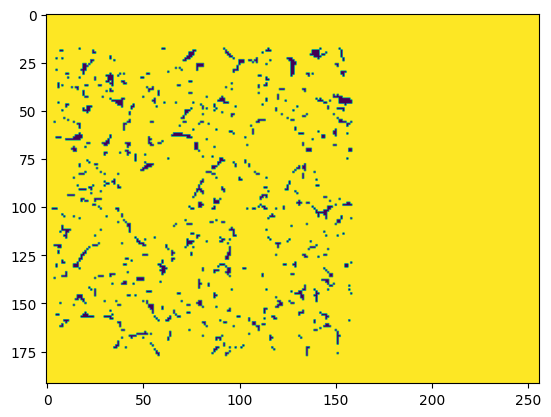

In [5]:
plt.imshow(state_seq_whole[0,:,:,2])

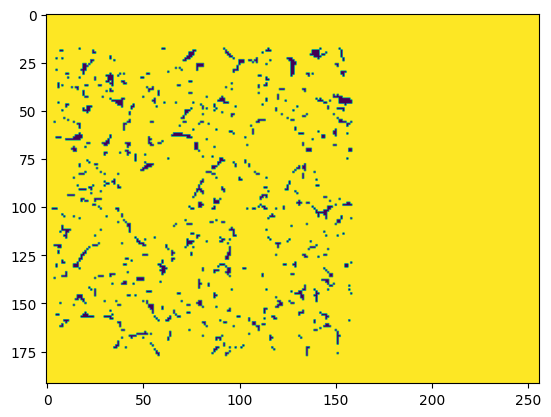

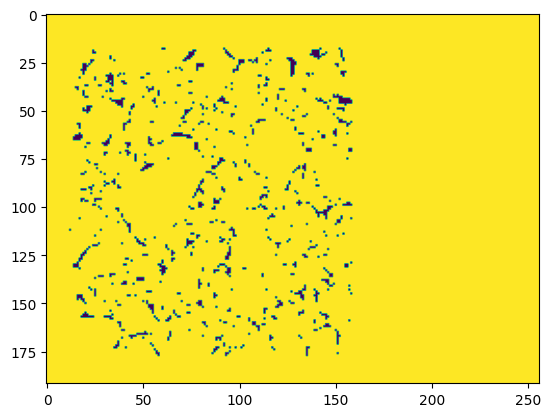

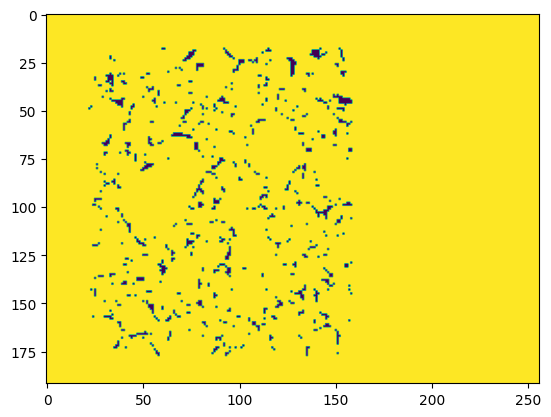

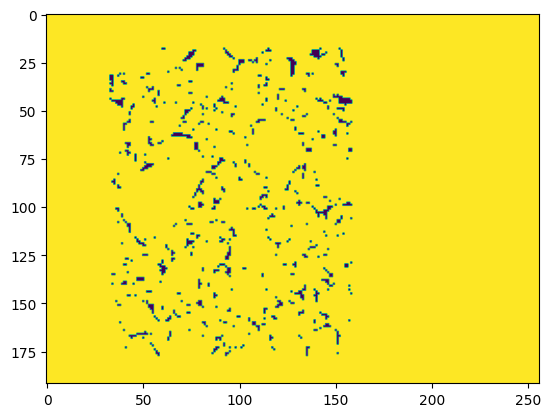

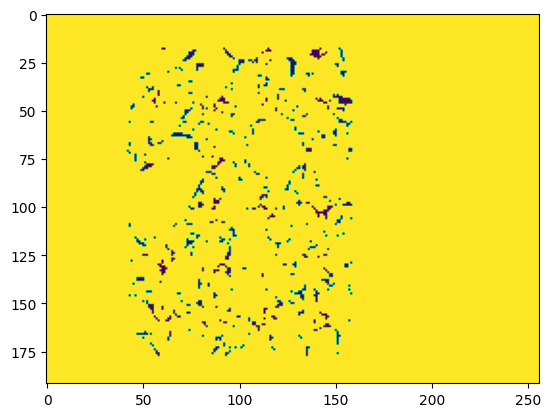

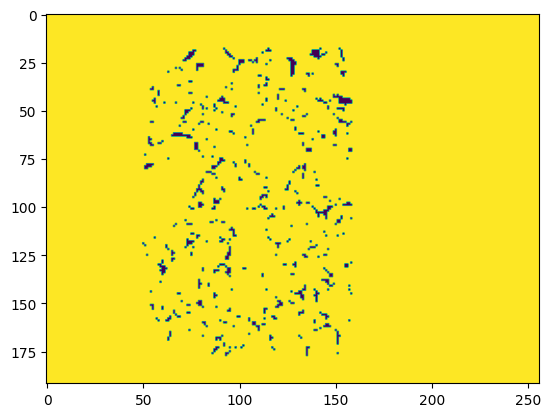

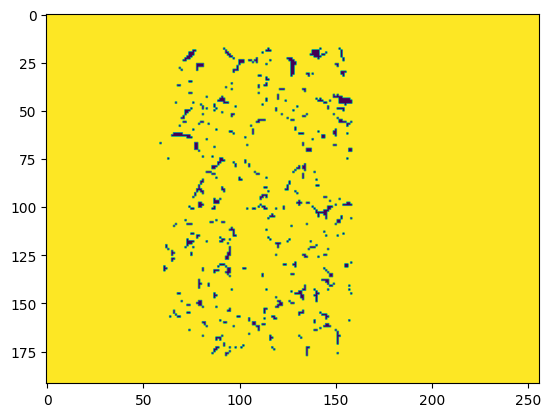

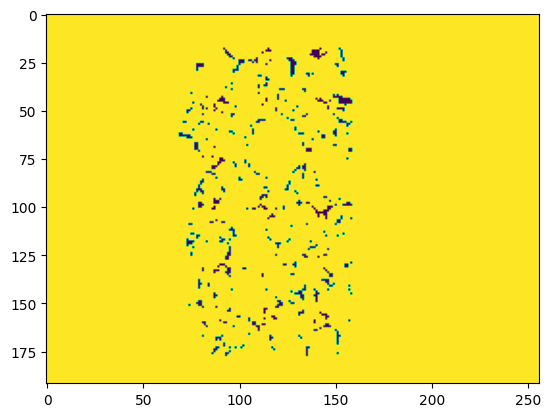

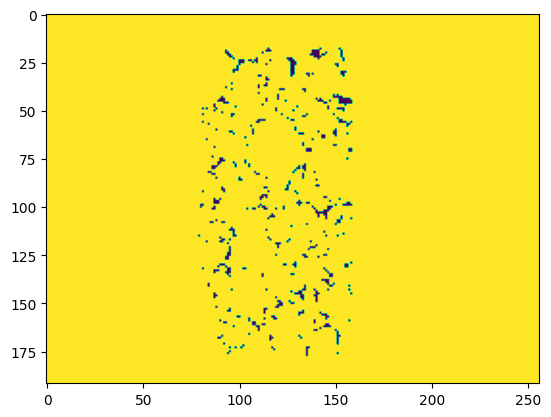

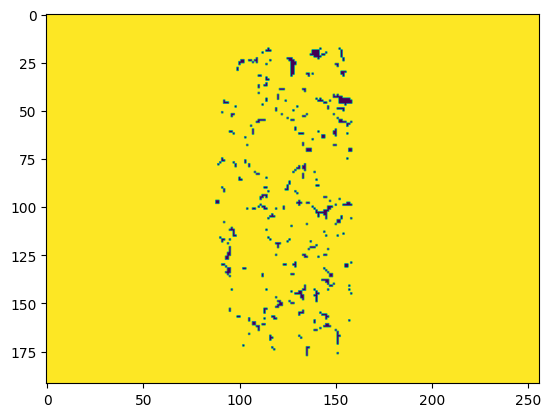

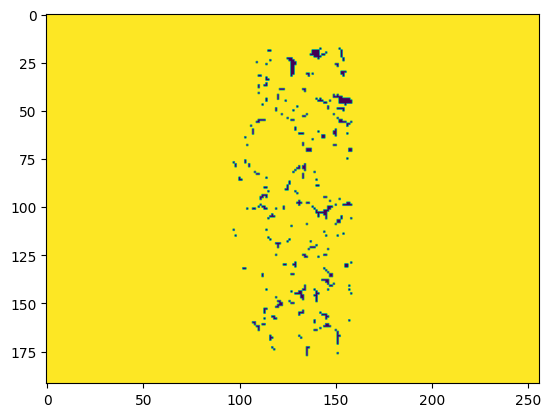

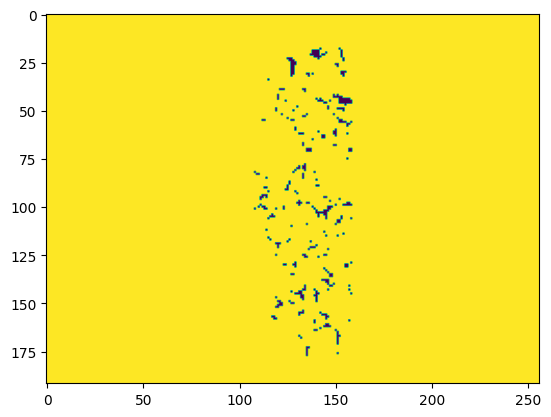

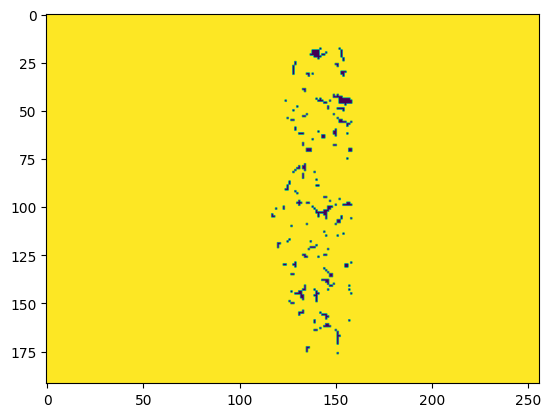

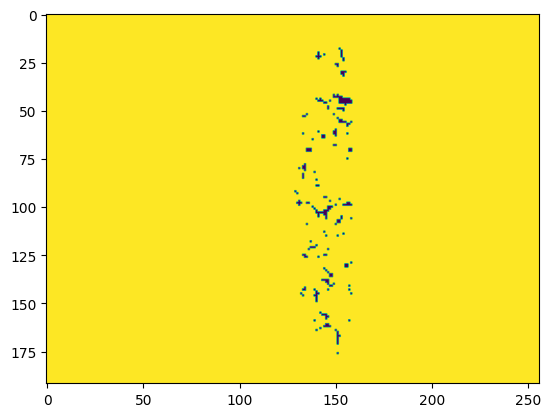

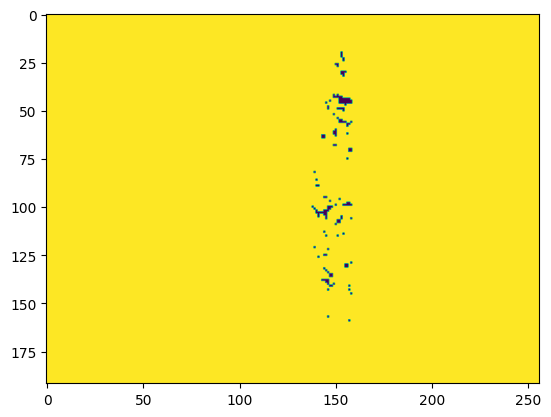

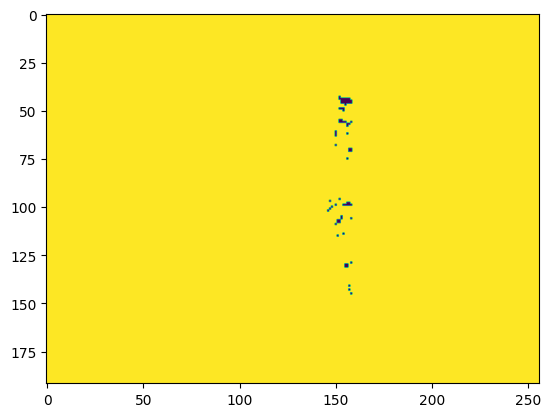

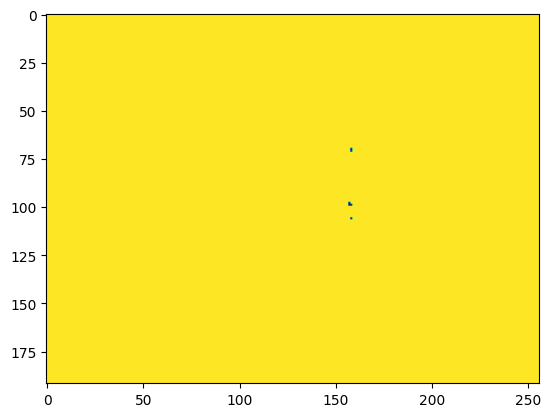

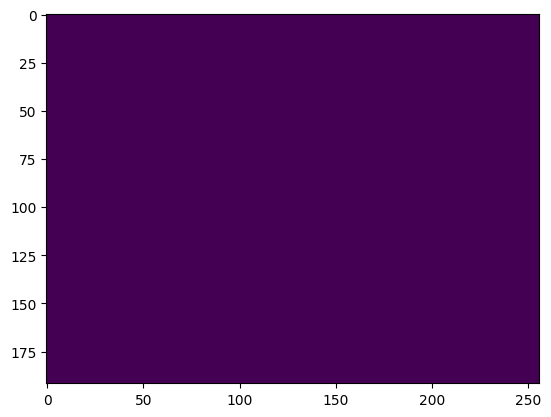

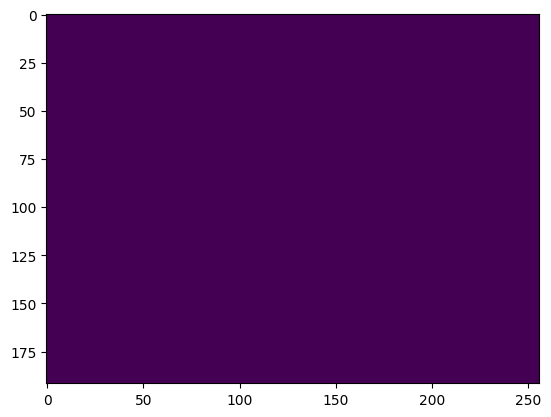

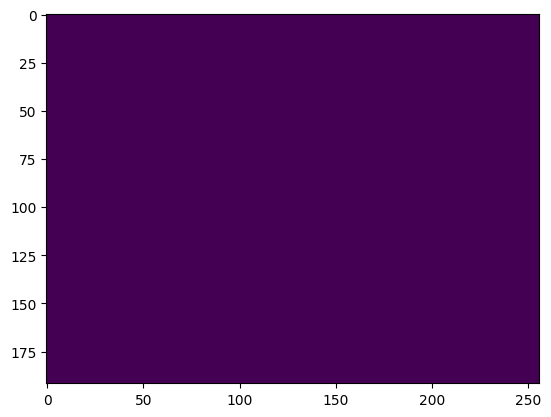

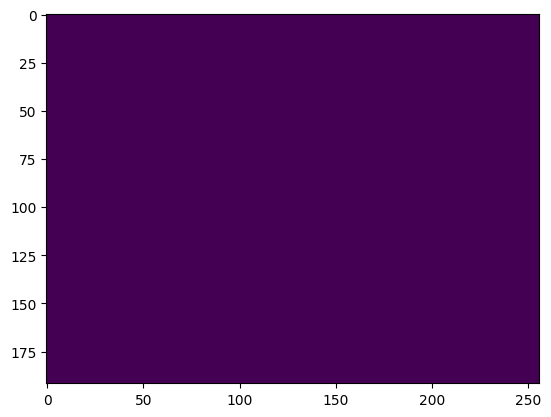

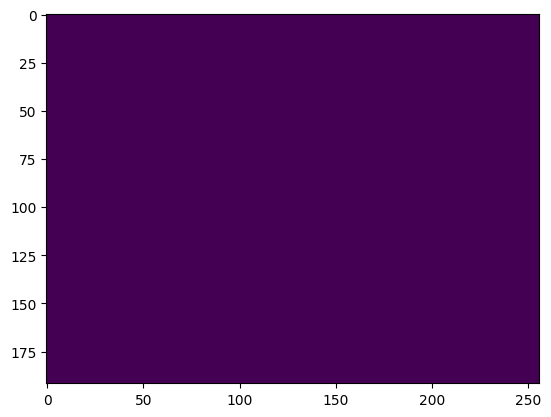

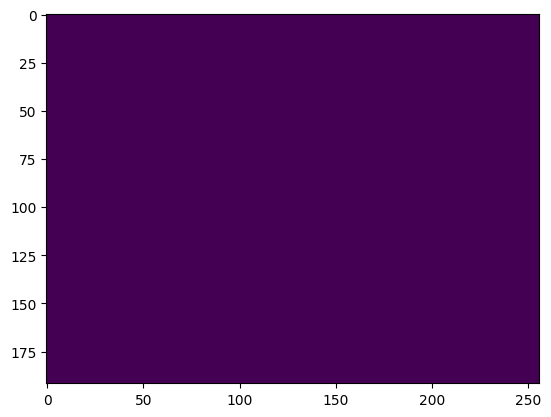

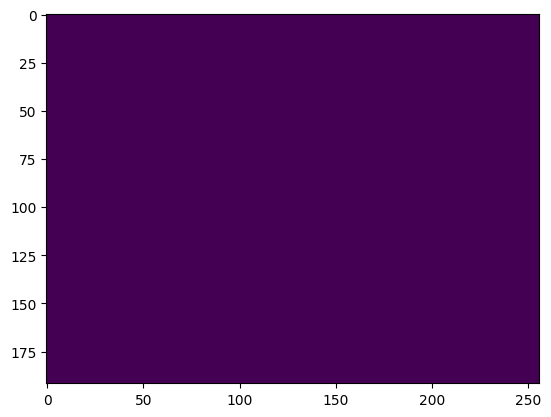

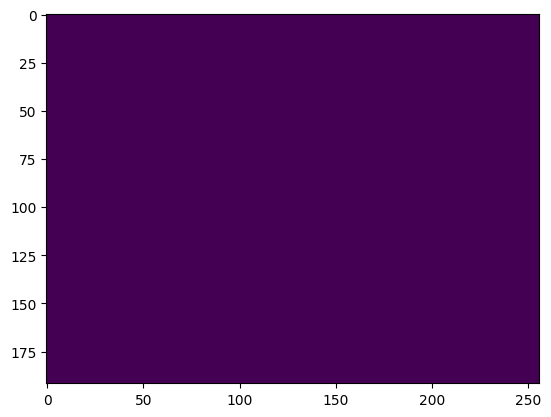

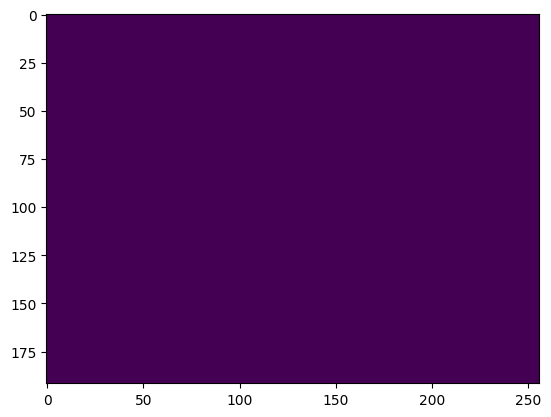

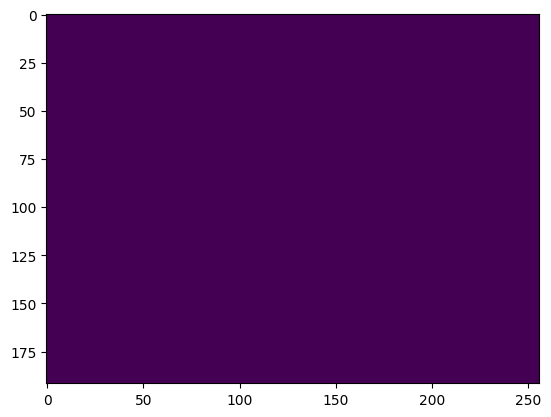

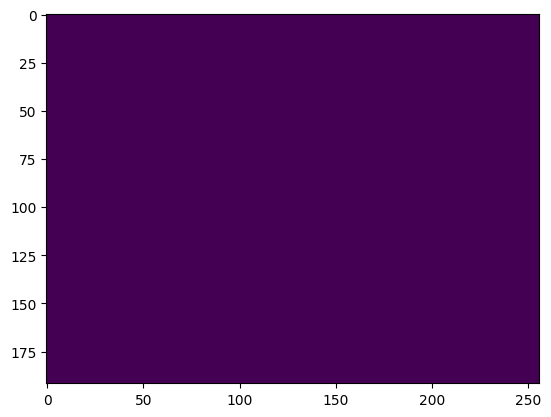

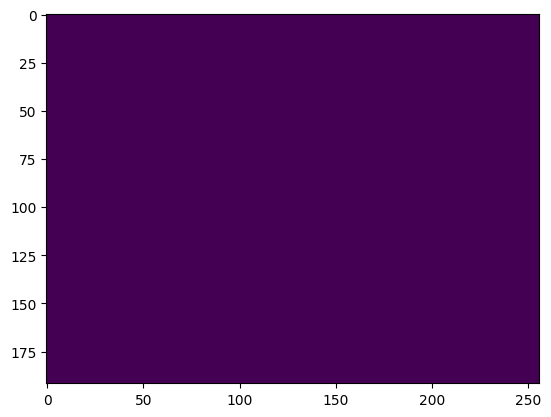

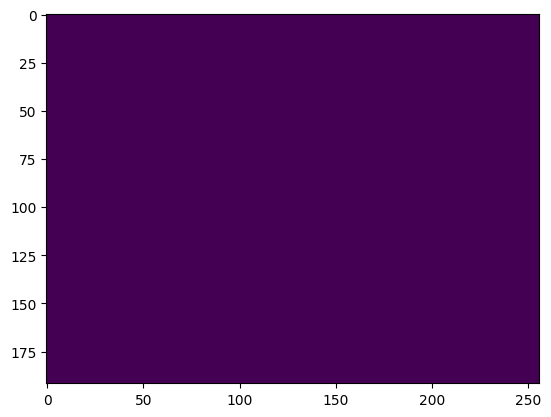

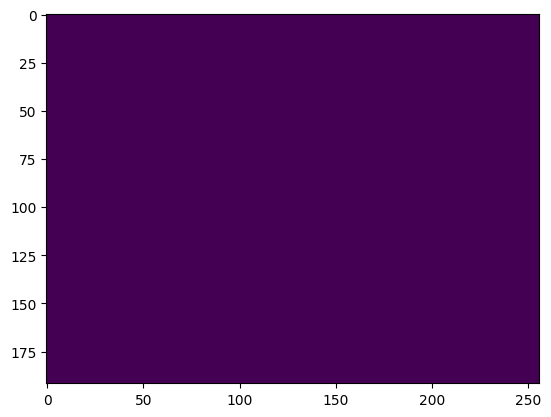

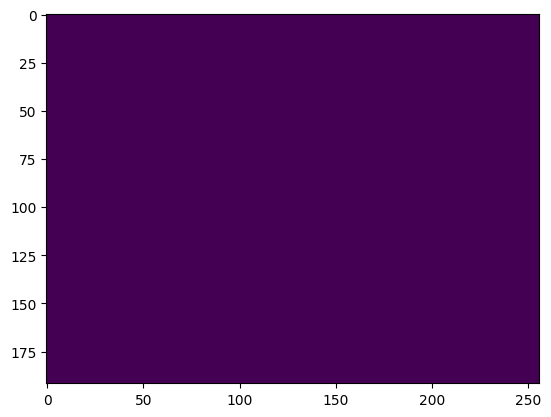

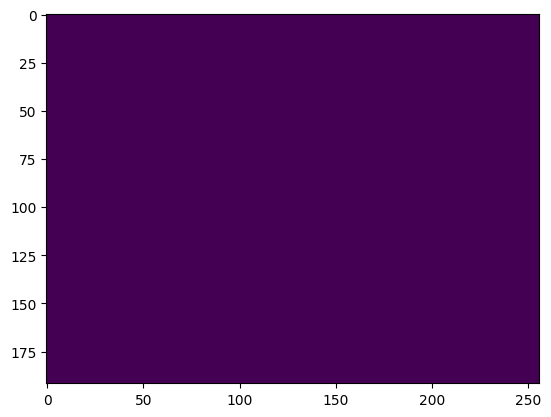

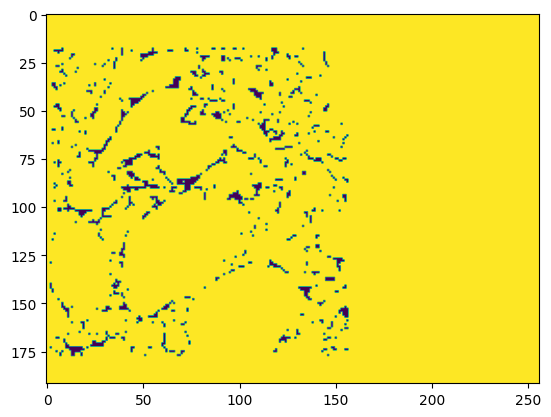

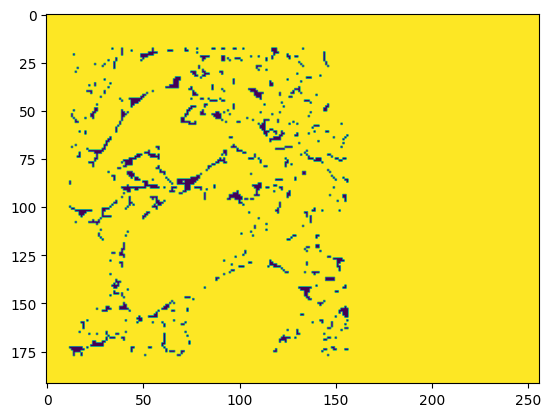

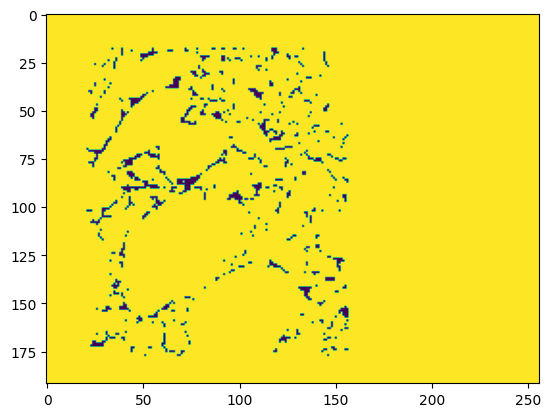

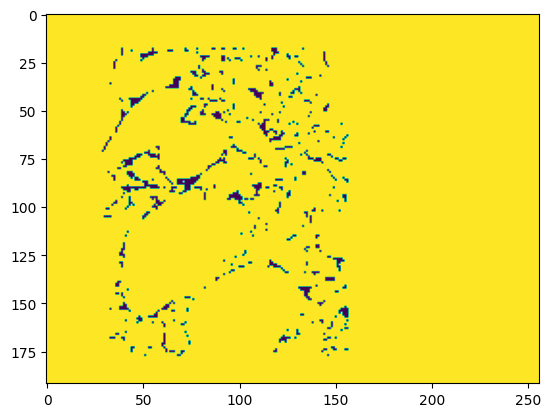

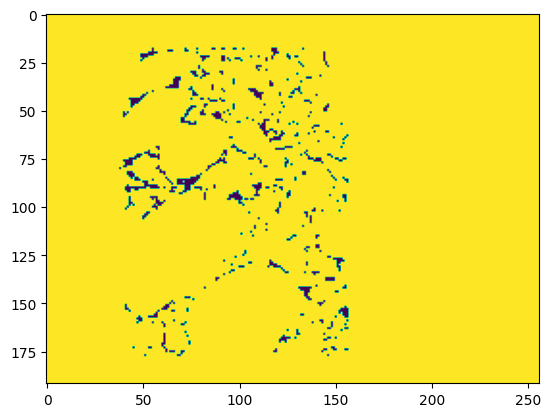

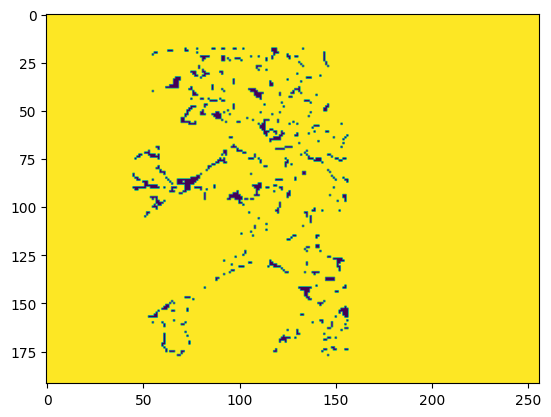

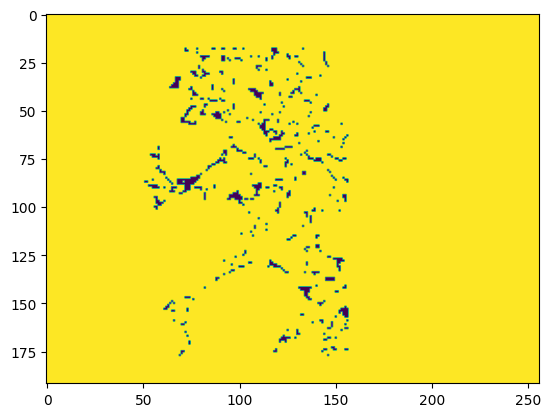

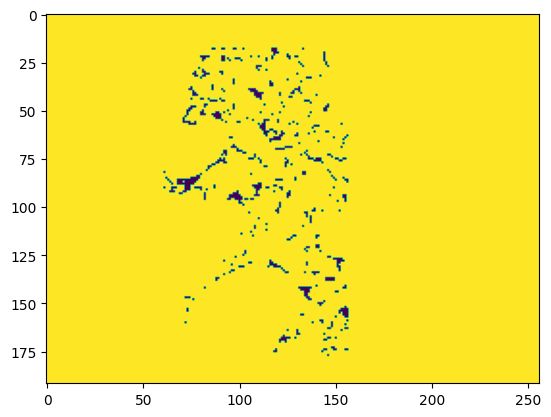

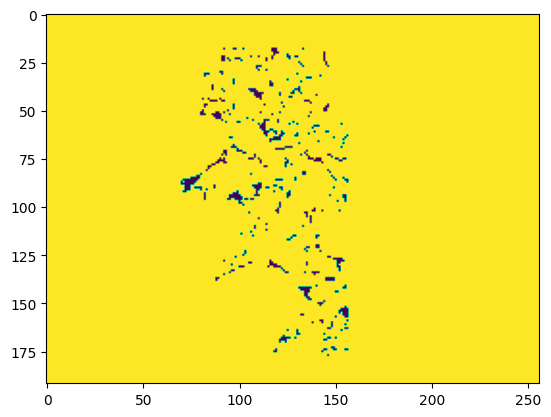

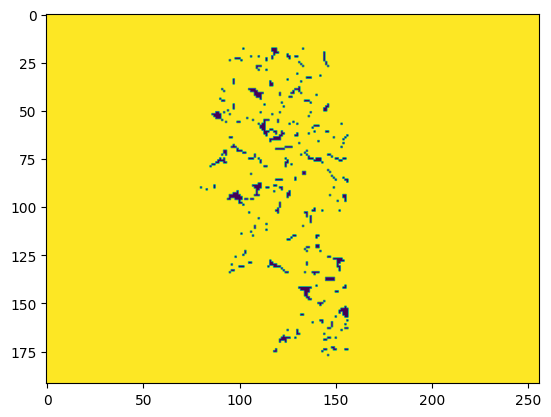

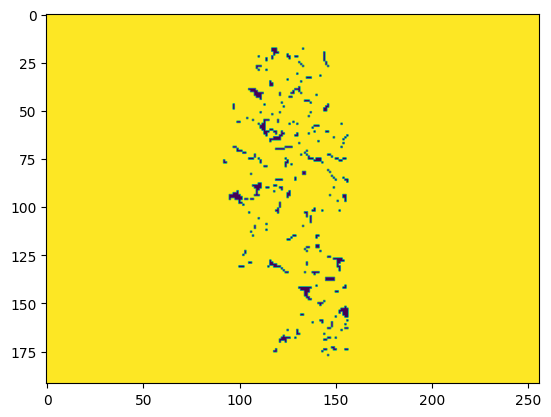

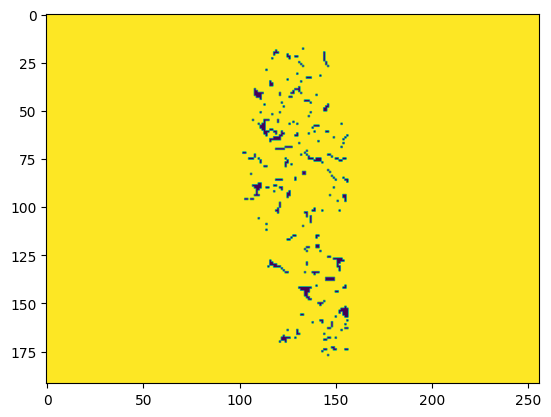

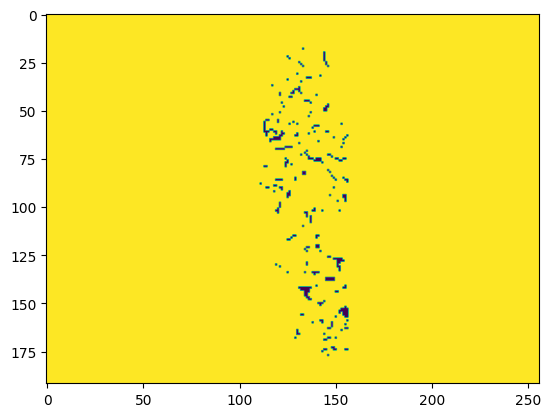

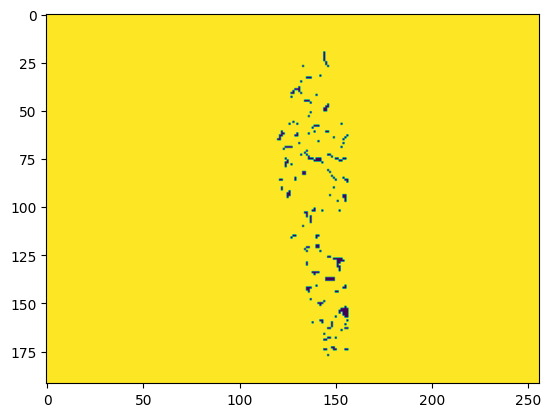

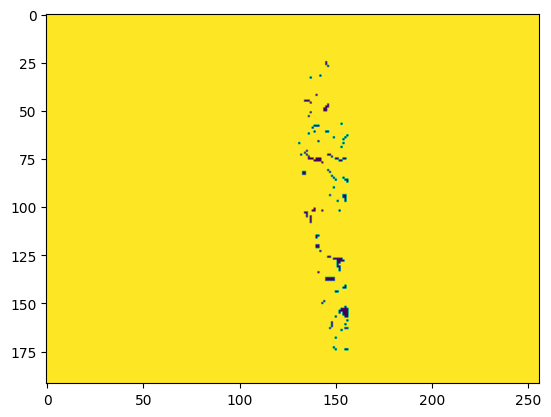

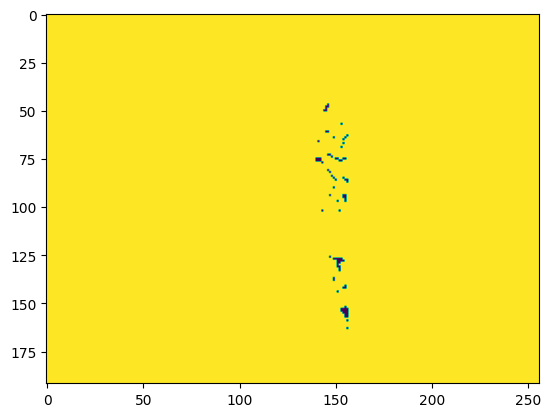

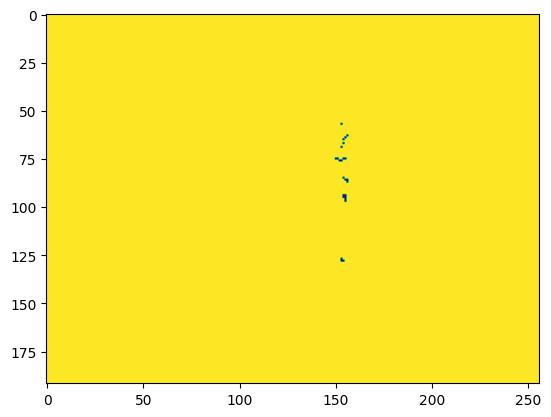

In [6]:
for i in range(50):
    # plt.imshow(state_seq_whole[i*3,:,:,0]) # temperature
    plt.imshow(state_seq_whole[i,:,:,2])  # microstructure
    plt.show()

## Training

In [7]:
# Create tf.dataset
dataset_input = tf.data.Dataset.from_tensor_slices((state_seq_norm[0][:,:,:,:3],vel_seq_norm[0][:,:,:,:2]))
dataset_label = tf.data.Dataset.from_tensor_slices((state_seq_norm[0][:,:,:,-3:],vel_seq_norm[0][:,:,:,-2:]))
dataset = tf.data.Dataset.zip((dataset_input, dataset_label))
dataset = dataset.shuffle(buffer_size = 2192) 
dataset = dataset.batch(4) # changed to 4 from 8 because data too big for 8

In [ ]:
tf.keras.backend.clear_session()
parc = model.PARCv2(n_state_var = 3, n_time_step = 1, step_size= 1/15, solver = "rk4", mode = "differentiator_training")
parc.differentiator.load_weights('class5_mse_1200epoch.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999))
parc.fit(dataset, epochs = 200, shuffle = True)

Epoch 1/200


In [ ]:
parc.differentiator.save_weights('class5_mse_1400epoch.h5')

## Validation

In [4]:
# change to folders_test for test data (but also need to change above? becuase below _test versions not used?)
state_seq_whole, vel_seq_whole = clip_raw_data(folders)
state_seq_norm_test = data.data_normalization_test(state_seq_whole, state_seq_norm[1], state_seq_norm[2], 3)
vel_seq_norm_test = data.data_normalization_test(vel_seq_whole, vel_seq_norm[1], vel_seq_norm[2], 2)

class5_2
class5_3
class5_4
class5_5
class5_6
class5_8
class5_9
class5_10
class5_11
class5_13
class5_14
class5_15
class5_16
class5_19
class5_21
class5_22
class5_23


In [135]:
state_seq_norm_test.shape

(545, 192, 256, 6)

In [60]:
vel_seq_norm_test.shape

(125, 192, 256, 4)

#### Load Model

In [17]:
tf.keras.backend.clear_session()
parc_rk = model.PARCv2(n_state_var = 3, n_time_step = 14, step_size= 1/15, solver = "rk4")
parc_rk.compile()
parc_rk.differentiator.load_weights('class5_mse_1200epoch.h5')
# parc_rk.integrator.load_weights('parc2_int_rk4.h5')

In [ ]:
# train new cases 0, 33, 70, ...
# test new cases 0, 37, ...
idx = 0
state_var_init = tf.cast(state_seq_norm[0][idx:idx+1,:,:,:3], tf.float32)
velocity_init = tf.cast(vel_seq_norm[0][idx:idx+1,:,:,:2], tf.float32)
input_seq_current = tf.concat([state_var_init, velocity_init],axis = -1)
# input_seq_current = state_var_init

state_whole = []
vel_whole = []
for ts in range(30):
    input_seq_current, update = parc_rk.explicit_update(input_seq_current)
    state_whole.append(input_seq_current[:,:,:,:3])
    vel_whole.append(input_seq_current[:,:,:,3:])
state_pred = tf.concat(state_whole, axis = -1).numpy()
vel_pred = tf.concat(vel_whole, axis = -1).numpy()

In [86]:
state_pred.shape

(1, 192, 256, 90)

In [63]:
state_seq_whole.shape

(125, 192, 256, 6)

In [ ]:
for i in range(30):
    fig, ax = plt.subplots(1,2) # switch to (1,2) for horizontal
    ax[0].imshow(state_seq_whole[i+idx, :, :, 3])
    ax[1].imshow(state_pred[0, :, :, i * 3], vmin=0, vmax=1)
    if i % 5 == 0 or i == 29:
        # plt.savefig(f'train_class5_2_1400epoch{i}.png')
        plt.show()
    plt.close(fig)  # Close the figure after each iteration to free memory
